In [2]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import data_processing
reload(data_processing)
from data_processing import *
import os
from scipy.signal import periodogram, find_peaks

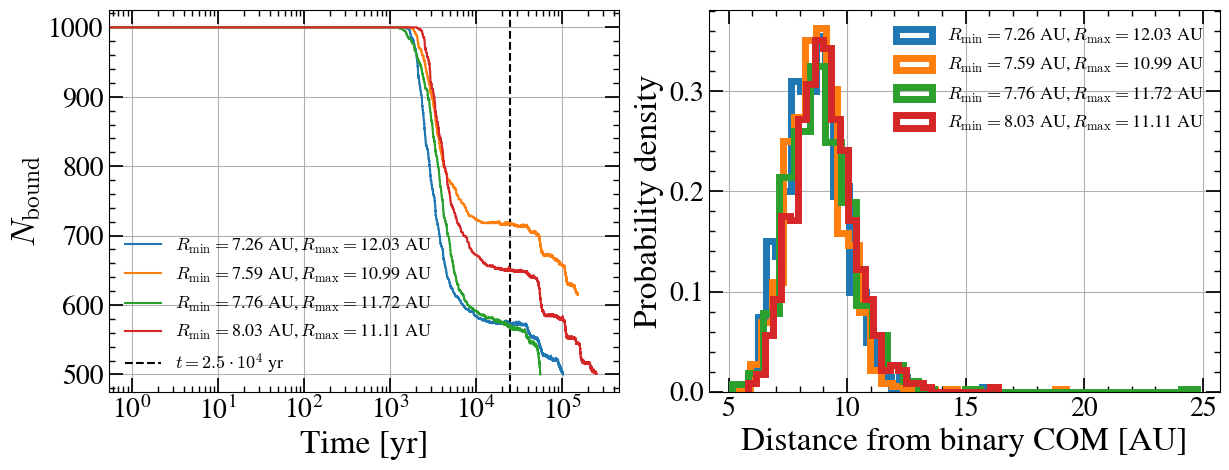

The inner and outer radii at 1 sigma are [ 7.99880008  8.08126932  8.07885872  8.33241152] and [ 9.22614726  9.28245307  9.55747754  9.59513866]. This gives a mean of 8.12 and 9.42 AU.
The inner and outer radii at 2 sigma are [ 7.38512648  7.48067745  7.33954931  7.70104795] and [  9.83982085   9.88304494  10.29678694  10.22650223]. This gives a mean of 7.48 and 10.06 AU.


In [2]:
plateau_histogram()

In [86]:
# Based on plateau_histogram
def mass_loss(dirs: list = ['/data2/AMUSE-KL-vdvuurst-pouw-badoux/Data-lucas/amuseKL-output/vary_radii-True/snapshots-rmin7.265-rmax12.025',
                    '/data2/AMUSE-KL-vdvuurst-pouw-badoux/Data-lucas/amuseKL-output/r_min-7.589-r_max-10.989/snapshots-rmin7.589-rmax10.989',
                    '/data2/AMUSE-KL-vdvuurst-pouw-badoux/Data/r_min-7.625-r_max-12.025-vary_radii-True/snapshots-rmin7.763-rmax11.723',
                    '/data2/AMUSE-KL-vdvuurst-pouw-badoux/Data/r_min-7.625-r_max-12.025-vary_radii-True/snapshots-rmin8.027-rmax11.107'],
                    savedir: str | None = None):
    """ docstring
    """
    dirs = np.array(dirs)
    idxs = np.array([25,75,125,175,225])*1e3 # Timestamps marking a plateau (decided by eye)
    idxs = idxs.astype(np.int64)
    # Create labels based on what snapshot file we are looking at
    labels = []
    for dir in dirs:
        if dir.endswith('/'):  
            dir = dir[:-1]  # Do not include final backslash
        rmin,rmax = os.path.split(dir)[-1].split('-')[1:]
        if 'rmin' in rmin:
            rmin= rmin[4:]
        if 'rmax' in rmax:
            rmax = rmax[4:]
        rmin,rmax = float(rmin),float(rmax)
        label = r'$R_{\rm min}=$'+f'{rmin:.2f}'+r' AU,$\,R_{\rm max}=$'+f'{rmax:.2f} AU'
        labels.append(label)

    # Save Nbound and time arrays for later processing
    nbounds = []
    times = []
    all_plateaus = []
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
    for i,dir in enumerate(dirs):
        head, _ = os.path.split(dir)
        rmin,rmax = os.path.split(dir)[-1].split('-')[1:]
        if 'rmin' in rmin:
            rmin= rmin[4:]
        if 'rmax' in rmax:
            rmax = rmax[4:]
        rmin,rmax = float(rmin),float(rmax)        
        nbound_path = os.path.join(head, f"Nbound_{rmin}-{rmax}.npy")
        nbound = np.load(nbound_path)
        nbounds.append(nbound)
        time = np.arange(len(nbound))
        times.append(time)

        ax.plot(time, nbound, label=labels[i])
        
        # print(idxs, len(nbound))
        plateaus = np.array([nbound[idx] for idx in idxs if idx < len(nbound)]) # Check the number of bound particles in each plateau idx
        all_plateaus.append(plateaus)

    for idx in idxs:
        ax.axvline(idx, c='k', zorder=0, ls='--')
        
    ax.legend(frameon=False, fontsize=15)
    ax.set_xlabel('Time [yr]')
    ax.set_ylabel(r'$N_\text{bound}$')
    # ax.semilogx()
    ax.grid(which='both')

    # for i, snapshot_dir in enumerate(dirs):
    #     file = get_sorted_files(snapshot_dir)[file_idx] #take the snapshot at file_idx years, i.e., 25 kyr
    #     data = read_set_from_file(file)

    #     _, _, _, ecc, _, _, _, _ = get_disk_orbital_elements(data)
    #     bound = ecc < 1
        
    #     disk, _, com = dissect_system(data)
    #     disk.position -= com.position
    #     bound_disk_pos = np.linalg.norm(disk[bound].position.value_in(units.AU), axis=1)

    #     axes[1].hist(bound_disk_pos, density=True, bins=30, histtype='step', linewidth=5, label=labels[i])

    #     medians[i] = np.median(bound_disk_pos)
    #     stds[i] = np.std(bound_disk_pos)

    # axes[1].set_ylabel('Probability density')
    # axes[1].set_xlabel('Distance from binary COM [AU]')
    # axes[1].grid()
    # axes[1].legend(frameon=False, fontsize=13, loc='upper right')

    fig.tight_layout()

    if savedir is not None:
        filename = f'{savedir}/plateau_histogram.pdf'
        fig.savefig(filename, bbox_inches = 'tight')

    return nbounds, times, all_plateaus, labels

NOTE: i = 0 refers to the first plateau, not the initial number of particles!

BLUE LINE:
N/N_0 = [ 1.          0.91258741]
N_i+1 / N_i = [0.91258741258741261]
Mean decay: 0.91 +- 0.00

ORANGE LINE:
N/N_0 = [ 1.          0.93575419  0.87709497]
N_i+1 / N_i = [0.93575418994413406, 0.93731343283582091]
Mean decay: 0.94 +- 0.00

RED LINE:
N/N_0 = [ 1.          0.89984592  0.85053929  0.798151    0.77657935]
N_i+1 / N_i = [0.89984591679506931, 0.9452054794520548, 0.93840579710144922, 0.97297297297297303]
Mean decay: 0.94 +- 0.03

Mean decay wrt previous plateau over all runs: 93.46 +- 2.17 %


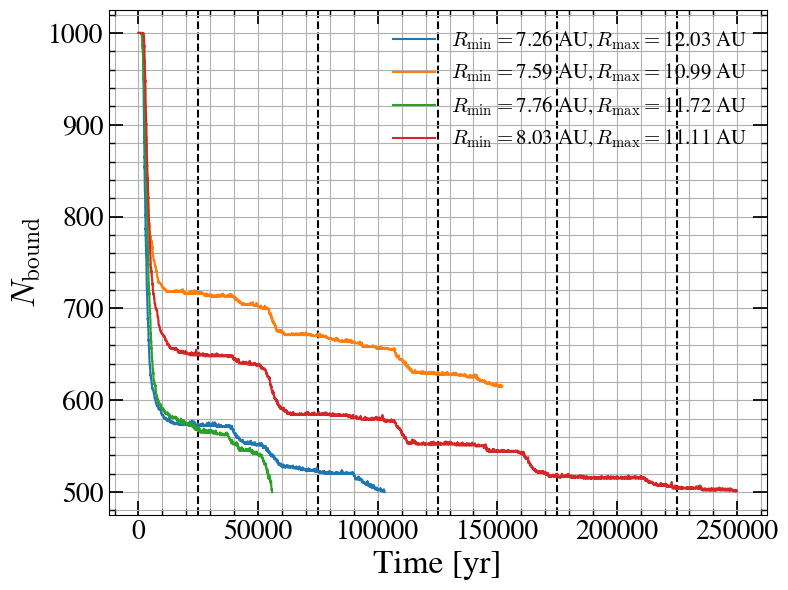

In [142]:
nbounds, times, plateaus, labels = mass_loss()
colors = ['blue','orange','green','red']
decays = []
print('NOTE: i = 0 refers to the first plateau, not the initial number of particles!')
print()
for i,p in enumerate(plateaus):
    if len(p) > 1:
        print(f'{colors[i].upper()} LINE:')
        print(f'N/N_0 = {p/p[0]}')
        decay_from_last_plateau = [p[j+1] / p[j] for j in range(len(p)-1)]
        print(f'N_i+1 / N_i = {decay_from_last_plateau}')
        decays.append(decay_from_last_plateau)
        print(f'Mean decay: {np.mean(decay_from_last_plateau*100):.2f} +- {np.std(decay_from_last_plateau*100):.2f}')
        print()

flat_decays = np.array([x for xs in decays for x in xs])
print(f'Mean decay wrt previous plateau over all runs: {np.mean(flat_decays*100):.2f} +- {np.std(flat_decays*100):.2f} %')
plt.show()


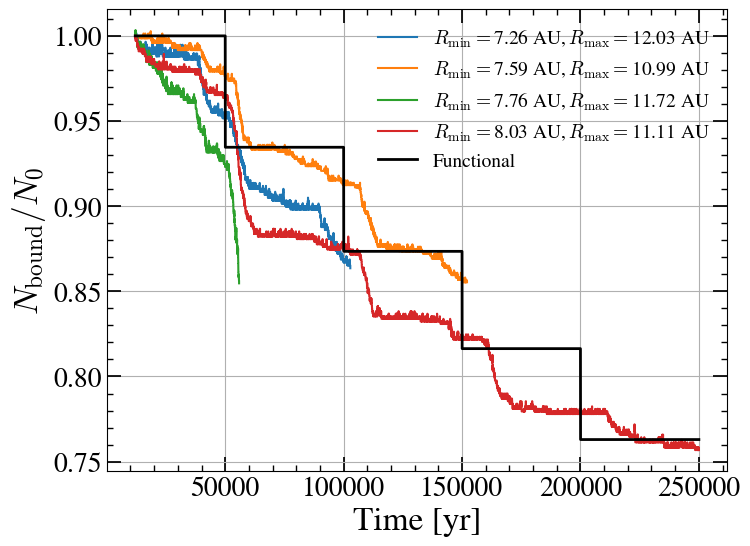

In [169]:
def func(t, M0, x, tau = int(50*1e3)):
    return M0 * x**(t // tau)

fig,ax = plt.subplots(figsize=(8,6))
for i,n in enumerate(nbounds):
    start = int(12  *1e3)
    n = n[start:]
    t = times[i][start:]
    plt.plot(t,n/n[0], label = labels[i])

t = times[3][12000:]
N_function = func(t, 1, 0.9346)
plt.plot(t,N_function, label = 'Functional', color = 'black', lw = 2)
ax.set(xlabel = 'Time [yr]', ylabel = r'$N_{\text{bound}} / N_0$')
ax.legend(frameon=False, fontsize=14)
ax.grid()
plt.show()

In [131]:
25*1e4 // (50*1e3)

5.0

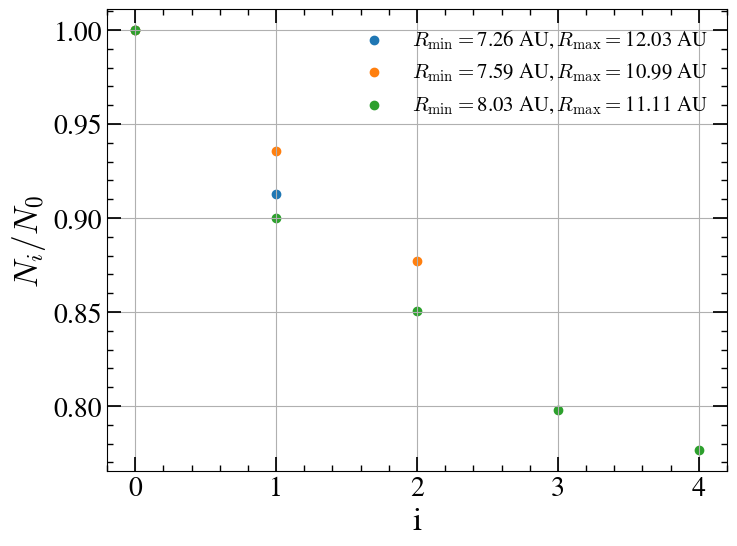

In [113]:
fig,ax = plt.subplots(figsize=(8,6))
for i,p in enumerate(plateaus):
    if len(p) > 1:
        plt.scatter(np.arange(len(p)),p/p[0], label = labels[i])
ax.set(xlabel = 'i', ylabel = r'$N_{i} / N_0$',xticks=[0,1,2,3,4])
ax.legend(frameon=False, fontsize=15)
ax.grid()
plt.show()

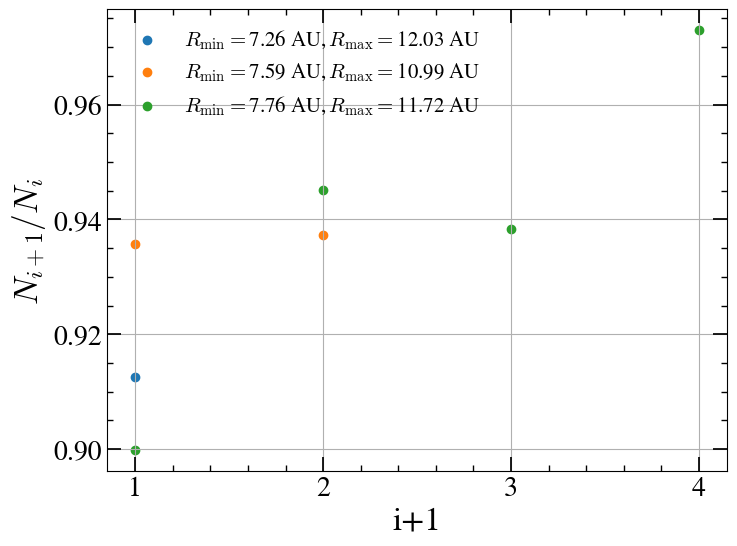

In [103]:
fig,ax = plt.subplots(figsize=(8,6))
for i,d in enumerate(decays):
    ax.scatter(np.arange(1,len(d)+1),d, label = labels[i])

ax.set(xlabel = 'i+1', ylabel = r'$N_{i+1} / N_i$',xticks=[1,2,3,4])
ax.legend(frameon=False, fontsize=15)
ax.grid()
plt.show()

## Empircal $t_{vZLK}$


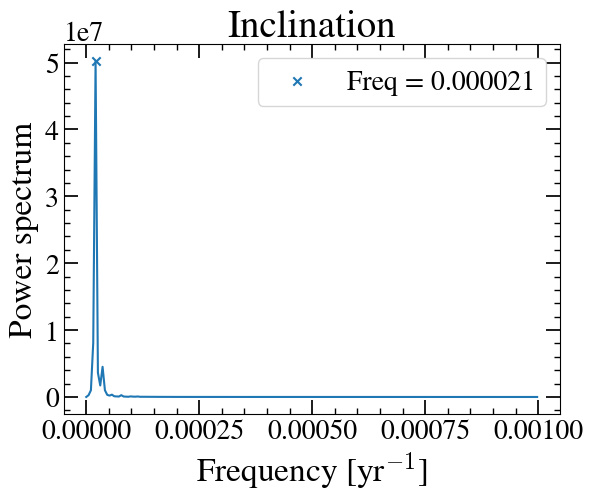

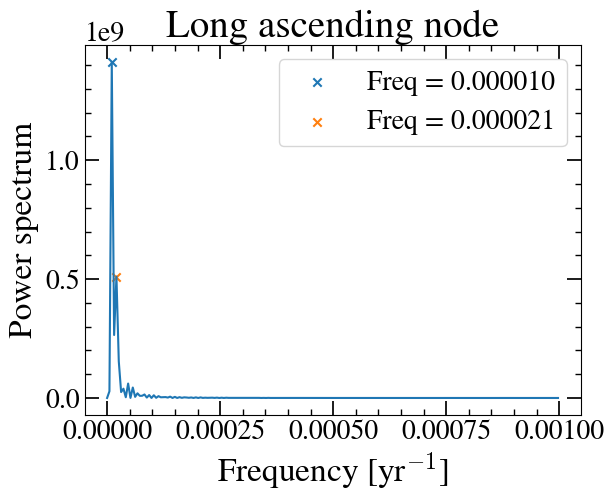

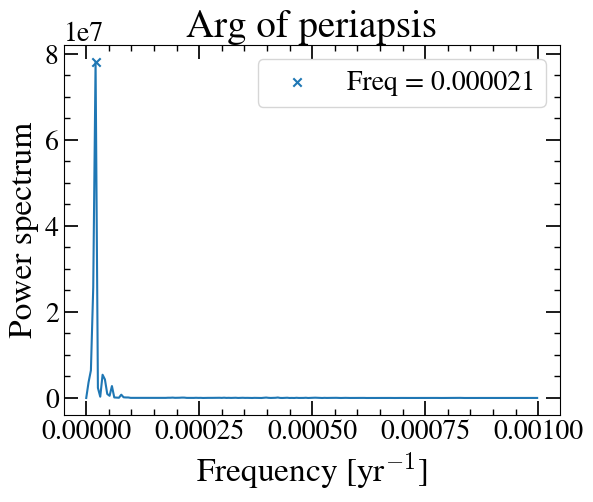

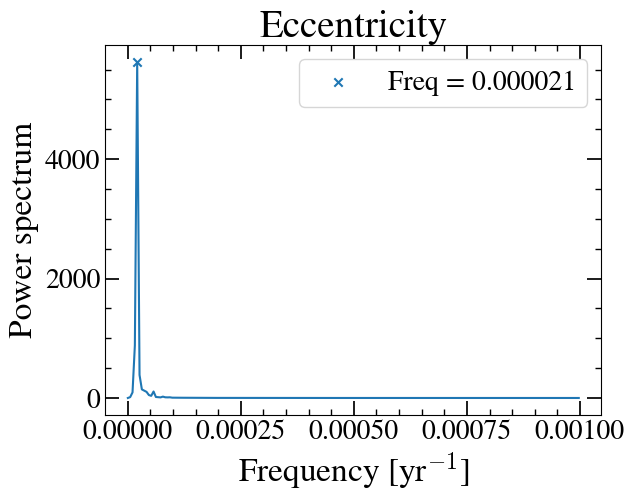

INCLINATION:
We find a vZLK timescale of 48375.0 yr
That is a relative error of 1.42%

ASCENDING NODE
We find a vZLK timescale of 48375.0 yr
That is a relative error of 1.42%

PERIAPSIS
We find a vZLK timescale of 48375.0 yr
That is a relative error of 1.42%

ECCENTRICITY
We find a vZLK timescale of 48375.0 yr
That is a relative error of 1.42%


In [9]:
from kl_analysis import _check_orbital_element_files_binary, average_every

bin_root = '/data2/AMUSE-KL-vdvuurst-pouw-badoux/hydro_validation/r_min-8.12-r_max-9.42-vary_radii-True/'
sin_root = '/data2/AMUSE-KL-vdvuurst-pouw-badoux/Data/m_orb-3.53-r_min-8.12-r_max-9.42-vary_radii-True/'
binary_snapshot_path = '/data2/AMUSE-KL-vdvuurst-pouw-badoux/hydro_validation/r_min-8.12-r_max-9.42-vary_radii-True/snapshots-rmin8.12-rmax9.42/'
single_snapshot_path = '/data2/AMUSE-KL-vdvuurst-pouw-badoux/Data/m_orb-3.53-r_min-8.12-r_max-9.42-vary_radii-True/snapshots-rmin8.12-rmax9.42/' 
bin_time, sin_time, eccs_single, incs_single, ascs_single, peris_single,\
eccs_disk, incs_disk, ascs_disk, peris_disk, eccs_binary, incs_binary, ascs_binary, peris_binary = _check_orbital_element_files_binary(bin_root,
                                                                                                                                        sin_root,
                                                                                                                                        binary_snapshot_path,
                                                                                                                                        single_snapshot_path)
def incl_periodogram(N = 500,show=True):
# N = 500 #smoothing
    incs_avg = average_every(incs_disk, N)

    # plt.plot(np.arange(len(eccs_avg)*500,step=500),eccs_avg)

    f, Pxx = periodogram(incs_avg,1/N)
    plt.figure()
    plt.title('Inclination')
    plt.plot(f,Pxx)

    peaks,_ = find_peaks(Pxx,1e7)
    freq_peaks= f[peaks]
    for p in peaks:
        plt.scatter(f[p],Pxx[p], label = f'Freq = {f[p]:.6f}', marker='x')
    plt.legend()
    plt.xlabel(r'Frequency [yr$^{-1}$]')
    plt.ylabel('Power spectrum')
    if show:
        plt.show()
    else:
        plt.close()

    return freq_peaks

def ascs_periodogram(N = 500,show=True):
# Different function since the peak threshold is different and you use a different array (and i am lazy)
# N = smoothing
    incs_avg = average_every(ascs_disk, N)

    # plt.plot(np.arange(len(eccs_avg)*500,step=500),eccs_avg)

    f, Pxx = periodogram(incs_avg,1/N)
    plt.figure()
    plt.title('Long ascending node')
    plt.plot(f,Pxx)

    peaks,_ = find_peaks(Pxx,0.4*1e9)
    freq_peaks= f[peaks]

    for p in peaks:
        plt.scatter(f[p],Pxx[p], label = f'Freq = {f[p]:.6f}', marker='x')
    plt.legend()
    plt.xlabel(r'Frequency [yr$^{-1}$]')
    plt.ylabel('Power spectrum')
    if show:
        plt.show()
    else:
        plt.close()

    return freq_peaks

def peris_periodogram(N = 500,show=True):
# Different function since the peak threshold is different and you use a different array (and i am lazy)
# N = smoothing
    incs_avg = average_every(peris_disk, N)

    # plt.plot(np.arange(len(eccs_avg)*500,step=500),eccs_avg)

    f, Pxx = periodogram(incs_avg,1/N)
    plt.figure()
    plt.title('Arg of periapsis')
    plt.plot(f,Pxx)

    peaks,_ = find_peaks(Pxx,1e7)
    freq_peaks= f[peaks]
    for p in peaks:
        plt.scatter(f[p],Pxx[p], label = f'Freq = {f[p]:.6f}', marker='x')
    plt.legend()
    plt.xlabel(r'Frequency [yr$^{-1}$]')
    plt.ylabel('Power spectrum')
    if show:
        plt.show()
    else:
        plt.close()

    return freq_peaks

def eccs_periodogram(N = 500,show=True):
# Different function since the peak threshold is different and you use a different array (and i am lazy)
# N = smoothing
    incs_avg = average_every(eccs_binary, N)

    f, Pxx = periodogram(incs_avg,1/N)
    plt.figure()
    plt.title('Eccentricity')
    plt.plot(f,Pxx)

    peaks,_ = find_peaks(Pxx,1e3)
    freq_peaks= f[peaks]
    for p in peaks:
        plt.scatter(f[p],Pxx[p], label = f'Freq = {f[p]:.6f}', marker='x')
    plt.legend()
    plt.xlabel(r'Frequency [yr$^{-1}$]')
    plt.ylabel('Power spectrum')
    if show:
        plt.show()
    else:
        plt.close()

    return freq_peaks

freq_peaks_incl = incl_periodogram(500)
freq_peaks_asc = ascs_periodogram(500)
freq_peaks_peris = peris_periodogram(500)
freq_peak_eccs = eccs_periodogram(500)
t_expected = 47.7 * 1e3 #yr

t_emp_incl = 1/freq_peaks_incl[0]
t_emp_asc = 1/freq_peaks_asc[1]
t_emp_peris = 1/freq_peaks_peris[0]
t_emp_eccs = 1 / freq_peak_eccs[0]

print("INCLINATION:")
rel_err = ((t_emp_incl - t_expected)/t_expected)*100
print(f"We find a vZLK timescale of {t_emp_incl} yr")
print(f'That is a relative error of {((t_emp_incl - t_expected)/t_expected)*100:.2f}%')
print()
print("ASCENDING NODE")
print(f"We find a vZLK timescale of {t_emp_asc} yr")
print(f'That is a relative error of {((t_emp_asc - t_expected)/t_expected)*100:.2f}%')
print()
print("PERIAPSIS")
print(f"We find a vZLK timescale of {t_emp_peris} yr")
print(f'That is a relative error of {((t_emp_peris - t_expected)/t_expected)*100:.2f}%')
print()
print("ECCENTRICITY")
print(f"We find a vZLK timescale of {t_emp_eccs} yr")
print(f'That is a relative error of {((t_emp_eccs - t_expected)/t_expected)*100:.2f}%')

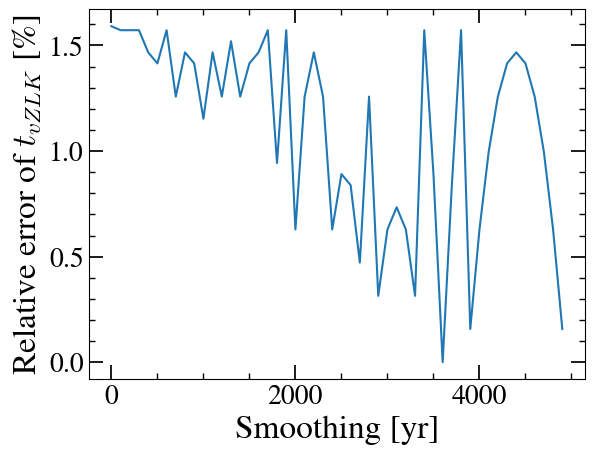

In [76]:
t_expected = 47.7 * 1e3 #yr

Ns = np.arange(5000,step=100)
rel_errs = []
for N in Ns:
    if N == 0:
        N = 1
    freq_peaks = incl_periodogram(N, False)
    t_emp = 1/freq_peaks[0]
    rel_err = ((t_emp - t_expected)/t_expected)*100
    rel_errs.append(rel_err)
    # print(f"We find a vZLK timescale of {t_emp} yr")
    # print(f'That is a relative error of {((t_emp - t_expected)/t_expected)*100:.2f}%')

plt.plot(Ns,rel_errs)
plt.ylabel(r'Relative error of $t_{vZLK}$ [%]')
plt.xlabel(f'Smoothing [yr]')
plt.show()